# A Bayesian Hierarchical Model for Operational Risk Capital Estimation

Loss Distribution Approach (LDA) has been widely used in the Advanced Measurement Approach (AMA) models.  Although the sunset of AMA approach is imminent, LDA may still be used in other contexts of capital estimation, such as capital allocation or benchmark models. 

In risk management, risk specialists usually conduct risk assessments to determine the frequency of a scenario or an actual loss event.  For instance, a loss of $250 millions may be deemed as an 1-in-100 year event.  Given the data have only been collected over, say, a 20-year span, treating the likelihood of this event as it is is believed to attribute too much weight to this event, assuming the assessment is correct.  Then the capital estimate purely based on historical data can be overestimated and even reach an level inadmissible by decision makers.  Traditionally, risk analytics is heavily complemented by the so-called subject matter expertise for reasons like this.  

As far as I have experienced, the popular practices normally use a frequentist or Fisherian framework, which does not explicitly incorporate human judgement into the model.  Instead, the process usually works as follows:  modelers estimate a parametric model using MLE and report a capital estimate using a selected percentile.  If the estimate is too high, stackholders push back the results.  Then the modelers have to be "creative" in producing an acceptable result.  Arts used to accomplish this goal include but are not limited to (1) finding "rationales" to exclude large loss events, (2) "fine-tuning" selection criteria to rationalize the use of a light-tailed distribution, such as log-normal distribution.

This notebook shows how to use **Stan** to estimate a log generalized t distribution using a Bayesian Hierarchical model and how to explicitly include risk assessments through the use of prior distributions.  

$
y \sim \mathcal{logT}(\nu, \mu, \sigma)
$

Log generalized t distribution has a degree-of-freedom parameter ($\nu$).  As $\nu$ goes to infinity, the log generalized t distribution converges to a log-normal distribution.



## Loss Generating Process

We assume there are three business units - A, B, and C.  A has three products - A1, A2, and A3.  B has two products  - B1 and B2.  C has three products - C1, C2, and C3. We assume the soundness of the enterprise risk management and culture affects all BUs through the likelihood of the rare events or the shape of the right tail - technically, all BUs share the same $\nu$.  Now, each BU has its own business environments.  For instance, A may be a credit card business; B may be an asset management business; and C may be a retail banking business.  Different business environments and competition in the market affect the variation of losses -- that is, products under the same BU share the same $\sigma$.  Finally, each products have its own level of risk profile influenced by its own management and business strategies -- that is, products have its own $\mu$.

$
y_{ijk} \sim \mathcal{logT}(\nu, \mu_{jk}, \sigma_j)
$

where $i$ denotes loss events, $j$ denotes BUs, and $k$ denotes products.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, t, gamma

total_n = 5000
prob_products = [0.2, 0.15, 0.08, 0.2, 0.02, 0.1, 0.15, 0.1] 
# count share for each products
n_products = [3, 2, 3]

mu_true = norm.rvs(9.5, 1, size = 8, random_state = 42)
print(mu_true)

[ 9.99671415  9.3617357  10.14768854 11.02302986  9.26584663  9.26586304
 11.07921282 10.26743473]


In [2]:
sum(prob_products)

1.0

In [0]:
sigma_true = [1.2, 1, 0.8]

In [0]:
nu_true = 5

In [0]:
product_n = [int(total_n * x) for x in prob_products]
sigma_vec = np.repeat(sigma_true, n_products)

In [0]:
np.random.seed(42)
input_list = [np.exp(t.rvs(nu_true, m, s, size = n)) for m, s, n in zip(mu_true, sigma_vec, product_n)]
out = np.concatenate(input_list).ravel()
d = dict({
    'loss': out,
    'Products': np.repeat(['A1', 'A2', 'A3', 'B1', 'B2', 'C1', 'C2', 'C3'], product_n)
})
data = pd.DataFrame.from_records(d)
data['BU'] = [x[0] for x in data['Products']]

In [7]:
data.head(10)

,Products,loss,BU
0,A1,42970.727133,A
1,A1,6037.979353,A
2,A1,108816.233361,A
3,A1,8878.172834,A
4,A1,45604.192351,A
5,A1,159914.754799,A
6,A1,2724.947315,A
7,A1,11226.180225,A
8,A1,11166.060457,A
9,A1,12316.116951,A


### Reporting Threshold

Operational Risk management normally imposes a reporting threshold.  The threshold is assumed to be $5000 in this exercise.

In [0]:
data = data[data['loss'] >= 5000]

In [9]:
data.shape

(4427, 3)

In [10]:
from collections import Counter
Counter(data['BU'])

Counter({'A': 1767, 'B': 1049, 'C': 1611})

In [11]:
Counter(data['Products'])

Counter({'A1': 877,
         'A2': 543,
         'A3': 347,
         'B1': 973,
         'B2': 76,
         'C1': 398,
         'C2': 736,
         'C3': 477})

In [0]:
prodTab = data.groupby(['BU', 'Products']).size().reset_index()

We can assume that the data have been collected for 20 years.  Then the average yearly frequency ($\lambda$) is:

In [13]:
counts = Counter(data['Products'])
[counts[x]/20 for x in counts]

[43.85, 27.15, 17.35, 48.65, 3.8, 19.9, 36.8, 23.85]

In [14]:
gamma.cdf(5, 8, 0.8)

0.0639433397274211

## The Model

The model is set up as a hierarchical model, where $\nu$ is estimated at the enterprise level, $\mu$ is at the product level, and $\sigma$ is at the BU level.  We use weakly informative priors on the parameters to incorporate human judgement explicitly.  

For instance, the Gamma prior on $\nu$ can be interpreted as a belief that the probability of $\nu$ less than 5 is `gamma.cdf(5, 8, 0.8)`, which is about 0.06, and less than 10 is 0.70.  

This prior quantifies the belief, which provides a basis for discussions.  One may argue that $Pr(\nu < 5) = 6\%$ expects too thin a tail, in which case she may propose the use of $Gamma(5, 0.5)$ expecting $Pr(\nu < 5) = 46\%$.  Rather than adjusting the capital estimates through manipulating the parametric assumptions or data assumptions, the hierarchical model incorporates subject matter experts' opinions or qualitative risk assessments in a more transparent and direct fashion.  In turn, qualitative risk specialists can have a more tangible disucssion with risk quants about the capital estimates as the belief is not quantified through the use of priors.

**Likelihood**:

$
y_{ijk} \sim \mathcal{logT}(\nu, \mu_{jk}, \sigma_j)
$

Priors:

$
\nu \sim \mathcal{Gamma}(8, 0.8)
$

$
\sigma_j \sim \mathcal{Half Cauchy}(0, \tilde{\tau})
$

$
\mu_{jk} \sim \mathcal{N}(\tilde{\mu}, \tilde{\sigma})
$

Hyperpriors:

$
\tilde{\tau} \sim \mathcal{Half Cauchy}(0, 2.5)
$

$
\tilde{\mu} \sim \mathcal{N}(0, 10)
$

$
\tilde{\sigma} \sim \mathcal{Half Cauchy}(0, 2.5)
$

In [15]:
! pip install arviz

In [0]:
import pystan
import arviz as az

### Stan Data

In [0]:
stan_data = {
    'N': data.shape[0],
    'J': len(Counter(data['BU'])),
    'K': len(Counter(data['Products'])),
    'L': np.log(5000),
    'bu': 1 + pd.CategoricalIndex(data['BU']).codes,
    'product': 1 + pd.CategoricalIndex(data['Products']).codes,
    'prod2Bu': 1 + pd.CategoricalIndex(prodTab['BU']).codes,
    'y': np.log(data['loss']),
    'lambda': [counts[x]/20 for x in counts],
    'S': 1000,
    'P': 0.95
}

### Stan Code

In [0]:
stan_code = """

functions { 
  real quantile(vector x, real p){
    int n;            // length of vector x
    real index;       // integer index of p
    int lo;           // lower integer cap of the index
    int hi;           // higher integer cap of the index
    real h;           // generated weight between the lo and hi
    real qs;          // weighted average of x[lo] and x[hi]
    n = num_elements(x);           
    index = 1 + (n - 1)*p;             
    lo = 1; 
    while ((lo + 1) < index) 
      lo = lo + 1; 
    hi = lo + 1; 
    h = index - lo; 
    qs = (1 - h)*sort_asc(x)[lo] + h*sort_asc(x)[hi];     
    return qs;                
  }
}
data {
  int<lower = 0> N; // number of losses
  int<lower = 0> J; // number of BUs
  int<lower = 0> K; // number of products
  real<lower = 0> L; //reporting threshold
  int<lower = 1, upper = J> bu[N]; //bu index
  int<lower = 1, upper = K> product[N]; //product index
  int<lower = 1, upper = J> prod2Bu[K]; //product to BU mapping
  vector<lower = L>[N] y; //log loss
  real<lower = 0> lambda[K]; // average frequency for each product
  int<lower= 0> S; //number of simulations
  real<lower = 0, upper = 1> P; //percentile
}
parameters {

  //hyper prior
  real<lower = 0> tau_tilde;
  real mu_tilde;
  real<lower = 0> sigma_tilde;
  
  // prior
  vector[K] mu;
  real<lower= 0> sigma[J];
  real<lower = 0> nu;
}
transformed parameters {
  //vectorize posterior sampling
  vector[N] mu_hat;
  real<lower = 0> sigma_hat[N];

  for(i in 1:N) {
    mu_hat[i] =  mu[product[i]] ;
    sigma_hat[i] = sigma[bu[i]];
   }
}
model {
  // hyper prior
  tau_tilde ~ cauchy(0, 2.5);
  mu_tilde ~ normal(0, 10);
  sigma_tilde ~ cauchy(0, 2.5);
   // prior
   nu ~ gamma(10, 1);
   mu ~ normal(mu_tilde, sigma_tilde);
   sigma ~ cauchy(0, tau_tilde);
  
  // likelihood
  y ~ student_t(nu, mu_hat, sigma_hat);
}
generated quantities {
  vector[K] kappa;  // p percentile of aggregate loss distribution
  vector[N] log_lik; // log likelihood
  for (i in 1:N) {
    log_lik[i] = student_t_lpdf(y[i] | nu, mu_hat[i], sigma_hat[i]);
  }
  for(k in 1:K) {
    vector[S] sim_loss;
    for(s in 1:S) {
      real tot_loss = 0;
      int f = poisson_rng(lambda[k]);
      if(f == 0) {
        tot_loss = 0;
      } else {
        for(d in 1:f) {
          real draw = student_t_rng(nu, mu[k], sigma[prod2Bu[k]]);
          while(draw < L) {
            draw = student_t_rng(nu, mu[k], sigma[prod2Bu[k]]);
          }
          tot_loss += exp(draw);
        }
      }
    sim_loss[s] = tot_loss;
    }
    kappa[k] = quantile(sim_loss, P);
  }
}
"""

In [19]:
model = pystan.StanModel(model_code = stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_81e389a53b522977cd6becd27769f501 NOW.


In [20]:
mcmc = model.sampling(
    data = stan_data, 
    chains=2, 
    iter=2000, 
    warmup=1000,
    seed = 42,
    init = [
            dict({'nu': 10, 'mu': np.repeat(10, 8), 'sigma': np.repeat(1, 3)}),
            dict({'nu': 10, 'mu': np.repeat(10, 8), 'sigma': np.repeat(1, 3)})
      ]
    )

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### Diagnostics

In [21]:
pystan.check_hmc_diagnostics(mcmc)

{'Rhat': True,
 'divergence': True,
 'energy': True,
 'n_eff': True,
 'treedepth': True}

### Summary of Posterior Distributions of Key Parameters

In [22]:
az.summary(mcmc, var_names = ['nu', 'mu', 'sigma', ])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
nu,6.658,0.574,5.597,7.680,0.015,0.010,1519.0,1519.0,1499.0,1632.0,1.0
mu[0],10.227,0.037,10.160,10.298,0.001,0.001,2685.0,2684.0,2678.0,1372.0,1.0
mu[1],9.838,0.047,9.743,9.920,0.001,0.001,2944.0,2943.0,2953.0,1716.0,1.0
mu[2],10.355,0.060,10.238,10.463,0.001,0.001,3566.0,3562.0,3571.0,1691.0,1.0
mu[3],10.994,0.035,10.926,11.059,0.001,0.000,3486.0,3486.0,3477.0,1576.0,1.0
mu[4],9.744,0.117,9.527,9.961,0.002,0.002,2962.0,2962.0,2934.0,1526.0,1.0
mu[5],9.532,0.041,9.453,9.606,0.001,0.001,2930.0,2928.0,2923.0,1377.0,1.0
mu[6],11.102,0.032,11.045,11.164,0.001,0.000,2898.0,2897.0,2919.0,1438.0,1.0
mu[7],10.356,0.039,10.284,10.427,0.001,0.000,4028.0,4028.0,4037.0,1419.0,1.0
sigma[0],0.968,0.022,0.925,1.008,0.000,0.000,2208.0,2208.0,2210.0,1664.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa00b81a048>,
      dtype=object)

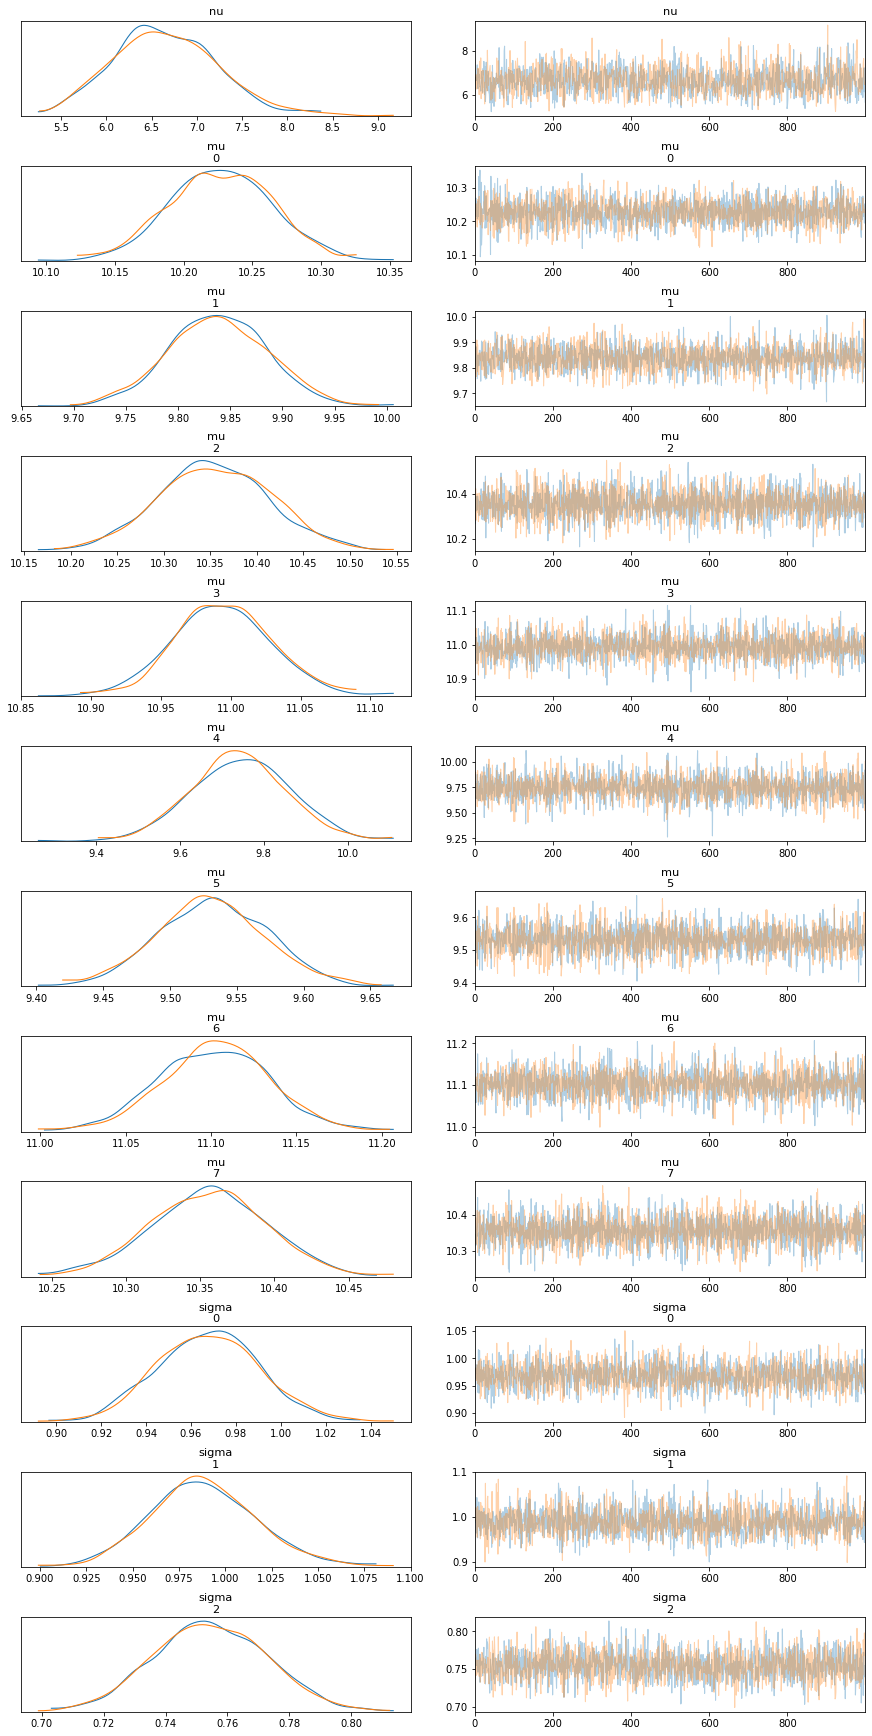

In [23]:
az.plot_trace(mcmc, var_names = ['nu', 'mu', 'sigma'])

The following table uses the posterior mean as the point estimate and compares with the acutal values.  We can observe the followings:

1. $\nu$ reflects the Gamma prior, which places a small probability on $\nu$ lower than 5.
2. $\mu$ reflects the effect of partial pooling.  The average of true $\mu$ is 10.05.  If the true $\mu$ for a product is greater than 10.05, the estimated $\mu$ is lower than the true value, and vice versa.
3. $\sigma$ reflects the Half Cauchy prior.

In [24]:
np.mean(mu_true)

10.050940682417068

In [25]:
post = az.summary(mcmc, var_names = ['nu', 'mu', 'sigma', ])
post['truth'] = np.concatenate((nu_true, mu_true, sigma_true), axis=None)
print(post[['mean', 'truth']])

            mean      truth
nu         6.658   5.000000
mu[0]     10.227   9.996714
mu[1]      9.838   9.361736
mu[2]     10.355  10.147689
mu[3]     10.994  11.023030
mu[4]      9.744   9.265847
mu[5]      9.532   9.265863
mu[6]     11.102  11.079213
mu[7]     10.356  10.267435
sigma[0]   0.968   1.200000
sigma[1]   0.989   1.000000
sigma[2]   0.755   0.800000


### Summary of Posterior Distributions of Prior Parameters

In [26]:
az.summary(mcmc, var_names = ['mu_tilde', 'sigma_tilde', 'tau_tilde'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_tilde,10.261,0.269,9.756,10.746,0.007,0.005,1434.0,1434.0,1986.0,1242.0,1.0
sigma_tilde,0.691,0.249,0.342,1.094,0.006,0.005,1526.0,1381.0,2081.0,1409.0,1.0
tau_tilde,1.366,0.917,0.205,2.948,0.020,0.016,2141.0,1711.0,2925.0,1407.0,1.0


### Summary of Posterior Distributions of Capital Estimates (95th Percentile)

Stan provides an opportunity to make inference using the HDI.  For instance, we can see that the capital estimates are right-skewed for the posterior mean is closer to the lower end of the 94% HDI.

In [27]:
az.summary(mcmc, var_names = ['kappa'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
kappa[0],5.848533e+06,807602.562,4.559722e+06,7.424799e+06,16851.138,12081.201,2297.0,2235.0,2389.0,1601.0,1.0
kappa[1],2.636276e+06,332418.227,2.114248e+06,3.311090e+06,6594.945,4742.185,2541.0,2457.0,2653.0,1702.0,1.0
kappa[2],2.776115e+06,332978.734,2.200252e+06,3.378005e+06,6539.768,4668.711,2592.0,2544.0,2630.0,1446.0,1.0
kappa[3],1.440561e+07,2399626.596,1.061765e+07,1.891579e+07,50283.629,36902.769,2277.0,2115.0,2461.0,1717.0,1.0
kappa[4],4.572456e+05,64402.152,3.387571e+05,5.769522e+05,1188.378,867.737,2937.0,2755.0,3066.0,1573.0,1.0
kappa[5],8.421492e+05,61831.485,7.186575e+05,9.488055e+05,1268.718,911.960,2375.0,2299.0,2513.0,1507.0,1.0
kappa[6],6.297255e+06,452590.188,5.544014e+06,7.192736e+06,9463.735,6746.304,2287.0,2251.0,2351.0,1815.0,1.0
kappa[7],2.084288e+06,152681.897,1.817862e+06,2.372501e+06,3025.200,2176.597,2547.0,2461.0,2743.0,1666.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa00c1d29b0>,
      dtype=object)

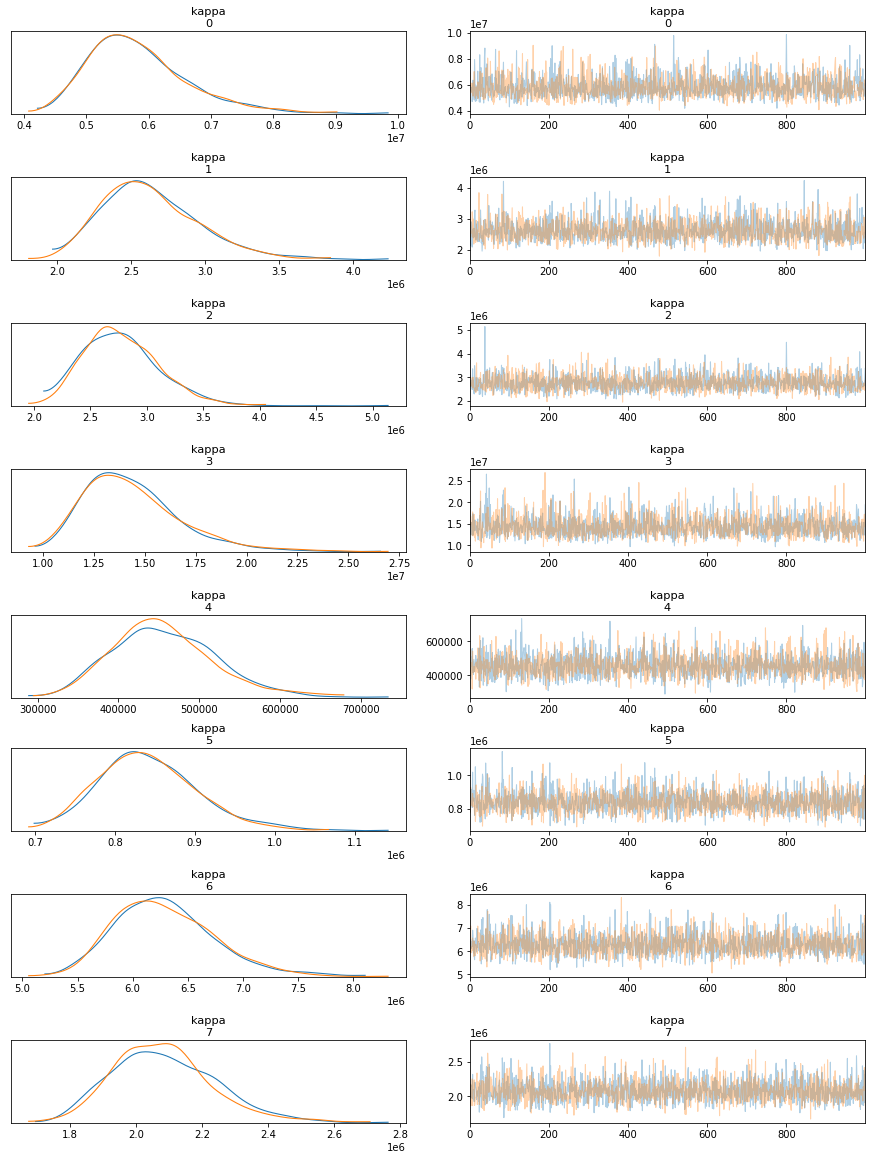

In [28]:
az.plot_trace(mcmc, var_names = ['kappa'])

The graphic below visualizes the point estimates for the 95th percentile for the aggregate loss distribution.  

<BarContainer object of 8 artists>

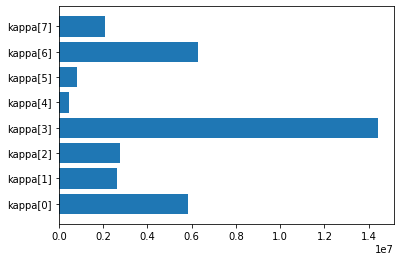

In [29]:
from matplotlib import pyplot as plt
kappaDf = az.summary(mcmc, var_names = ['kappa'])
fig, ax = plt.subplots()
ax.barh(kappaDf['mean'].index, kappaDf['mean'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa004efd908>,
      dtype=object)

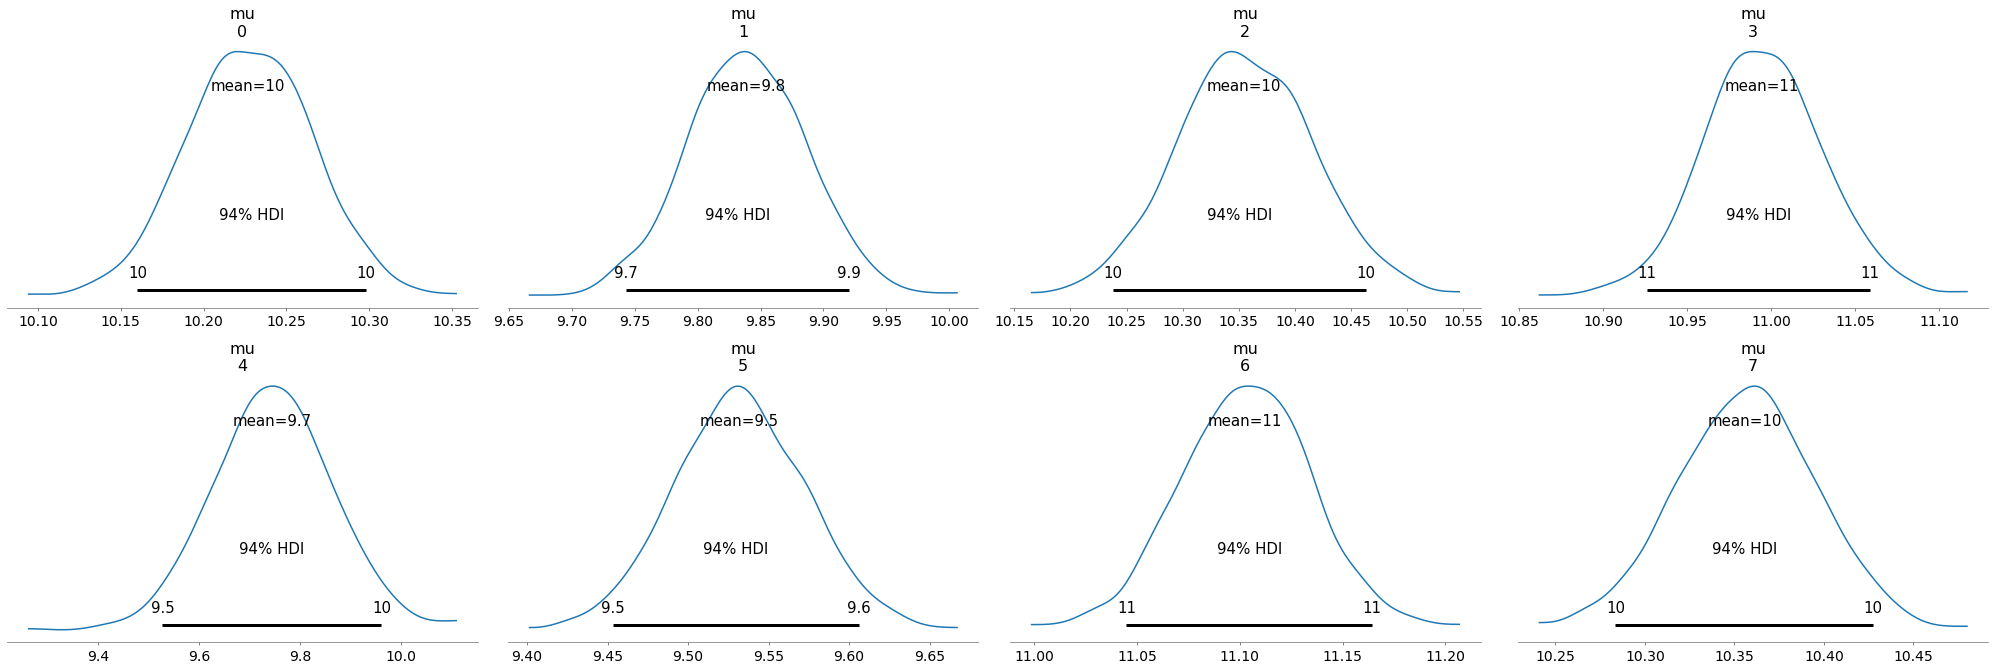

In [30]:
az.plot_posterior(mcmc, var_names = ['mu'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0051c7198>,
      dtype=object)

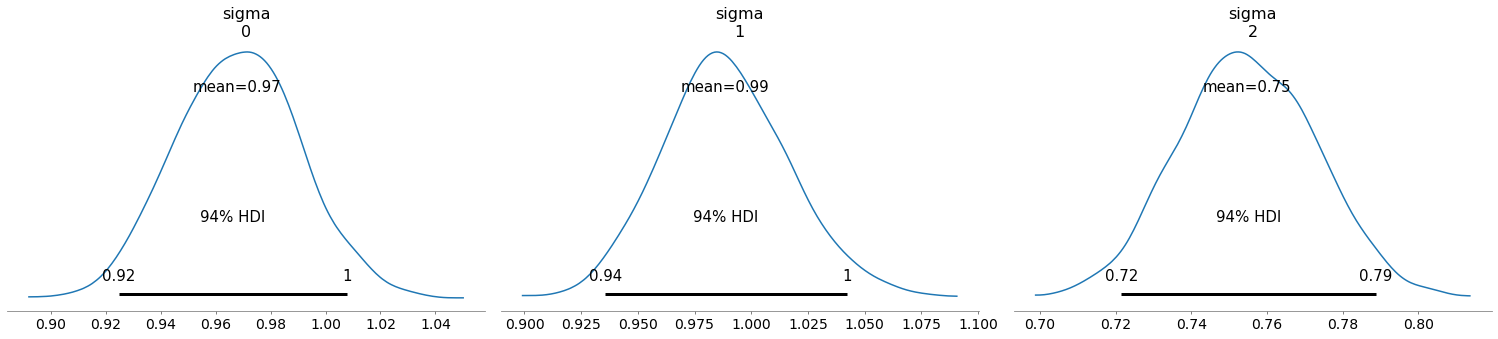

In [31]:
az.plot_posterior(mcmc, var_names = ['sigma'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa00497c390>],
      dtype=object)

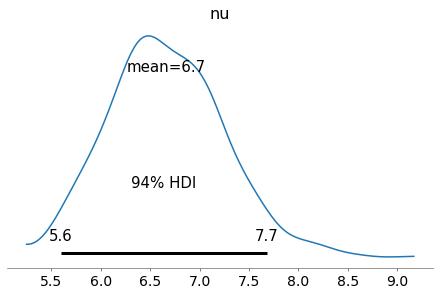

In [32]:
az.plot_posterior(mcmc, var_names = ['nu'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa004d32940>,
      dtype=object)

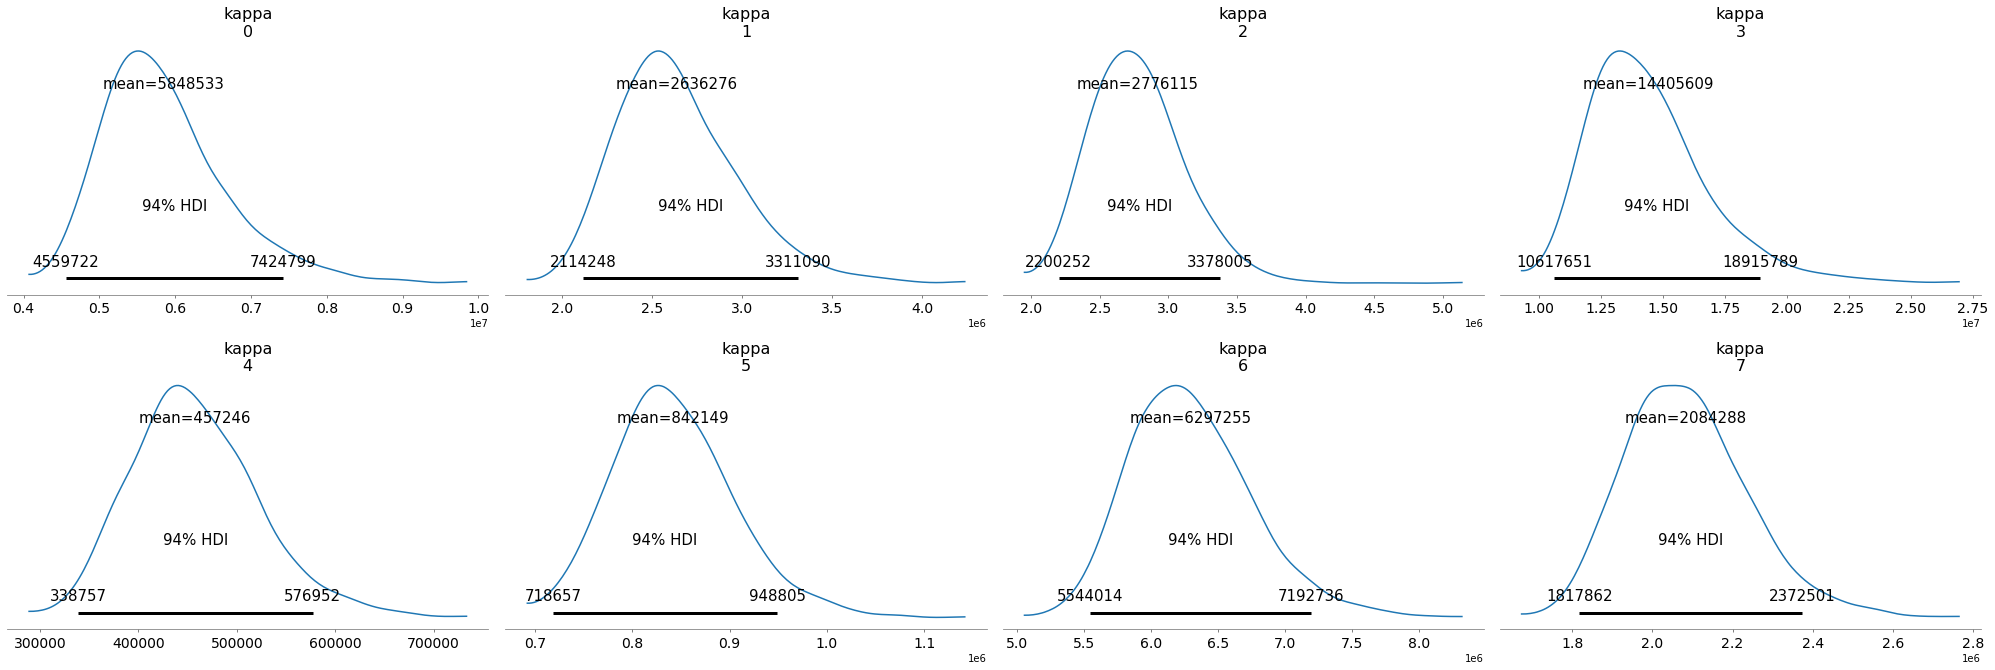

In [33]:
az.plot_posterior(mcmc, var_names = ['kappa'])

## Prediction Accuracy

You may want to estimate the model with a different set of priors or estimate a model without partial pooling.  Then you may want to select the best model in terms of prediction accuracy.  

> "Leave-one-out cross-validation (LOO-CV, or LOO for short) and the widely applicable information criterion (WAIC) are methods for estimating pointwise out-of-sample prediction accuracy from a fitted Bayesian model using the log-likelihood evaluated at the posterior simulations of the parameter values. "  -- from Rstan documentation

In [34]:
res = az.from_pystan(mcmc, log_likelihood="log_lik")
az.loo(res)

Computed from 2000 by 4427 log-likelihood matrix

         Estimate       SE
elpd_loo -6458.02    60.93
p_loo       12.43        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

## Concluding Remarks

Benefits of Bayesian Hierarchical Model for capital estimation:

- Account for the natural business hierarchy

- Allow parameters to be estimated at an appropriate level

- Explicitly (meaning that it is challengeable and falsifiable) incorporate risk specialists' judgements or qualitative risk assessments through the use of priors